<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Spatial_interpolation/ordinary_kriging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ordinay Kriging in R

Zia Ahmed, Unversity Buffalo

**Kriging** is a geostatistical interpolation method used to estimate values at unsampled locations in a spatial dataset. It is particularly useful when working with data that exhibits spatial autocorrelation, which means that values at nearby locations are more similar than those at distant locations. Kriging is widely used in fields such as geology, hydrology, environmental science, and geospatial analysis.

**Ordinary kriging** is the most widely used kriging method. It provides the best linear unbiased estimate of the variable of interest at unsampled locations, assuming a constant mean and stationary variance.


In ordinary kriging, the goal is to estimate a value Z(u) at an unsampled location u, based on a set of observed data values Z(xi) at known locations x_i. The mathematical formulation of ordinary kriging involves defining a linear estimator for Z(u) based on weighted averages of the observed data. The weights are determined by the spatial correlation structure of the data, as represented by the variogram.

Here's the mathematical representation of ordinary kriging:

1. **Estimation Equation:**
   - The estimation equation for ordinary kriging is given by:
     Z(u) = μ + Σλ_i [Z(x_i) - μ]
     
   - Where:
     - Z(u) is the estimated value at the unsampled location u.
     - μ is the global mean of the variable Z.
     - λ_i are the kriging weights assigned to each observed data point Z(x_i). These weights are determined by minimizing the estimation error variance while ensuring that the kriging estimator is unbiased (i.e., E[Z(u) - Z(u)] = 0).

2. **Kriging System:**
   - The kriging weights λ_i can be calculated by solving a system of linear equations known as the kriging system. The kriging system is constructed using the spatial correlations between Z(u) and the observed data points Z(x_i). It can be expressed as:
   
     Σλ_iγ(x_i, u) = γ_0
     
   - Where:
     - λ_i are the kriging weights.
     - γ(x_i, u) represents the spatial correlation, which is determined from the variogram model.
     - γ_0 is the variogram at the origin (lag distance = 0).

3. **Minimization of Estimation Variance:**
   - The kriging weights are chosen to minimize the estimation error variance, given by:
   
     Var[Z(u) - Σλ_iZ(x_i)] = Σλ_iγ(x_i, u) - γ_0

The primary goal of ordinary kriging is to find the kriging weights that provide the best linear unbiased estimate of Z(u). This means that the estimation error is minimized, and the estimate is unbiased, making it the best possible linear estimate given the available data and the spatial correlation structure represented by the variogram.

The specific details of implementing kriging, such as selecting the variogram model and estimating its parameters, can vary depending on the data and the geostatistical software used. The kriging weights and the estimation equation, as described above, form the core mathematical framework for kriging in geostatistics.

### Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314937 sha256=af790355ce39684e27dbed20f25838aa7acfb6fc246f160f40985d7d060364b0
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Check and Install Required R Packages

In [ ]:
%%R
pkg <- c('tidyverse', 'raster', 'rgdal','terra','tidyterra', 'maptools', 'sf', 'classInt',
         'RColorBrewer', 'tmap','tmaptools', 'gridExtra', 'devtools', 'data.table', 'gstat','Hmisc','corrplot',
         'ggmap','ggpmisc', 'plyr','spatstat','dismo','fields', 'moments', 'car')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Load R Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
library (tidyverse)
library (terra)
library (tidyterra)
library(raster)
library(RColorBrewer)
library(RStoolbox)
library(gridExtra)
library(latticeExtra)
library(data.table)
library(gstat)
library(classInt)
library(plyr)
library(spatstat)
library(dismo)
library(fields)
library(moments)
library(car)
library(ggpmisc)

### Data

The following data will be used in the exercise that can be found [here](https://github.com/zia207/r-colab/tree/main/Data/Spatial_interpolation).

1. train_data.csv

2. test_data.csv

2. GP_STATE.shp

3. GP_prediction_grid_data.csv

In [4]:
%%R
train<-read_csv('/content/drive/MyDrive/Data/Spatial_Interpolatiom/train_data.csv')
test<-read_csv('/content/drive/MyDrive/Data/Spatial_Interpolatiom/test_data.csv')
grid<-read_csv('/content/drive/MyDrive/Data/Spatial_Interpolatiom/GP_prediction_grid_data.csv')
state<-shapefile("/content/drive/MyDrive/Data/Spatial_Interpolatiom/GP_STATE.shp")

Rows: 368 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD_DES, FRG_DES
dbl (17): ID, STATE_ID, FIPS, x, y, SOC, ELEV, Aspect, Slope, TPI, K_Factor,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 101 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): STATE, COUNTY, NLCD_DES, FRG_DES
dbl (17): ID, STATE_ID, FIPS, x, y, SOC, ELEV, Aspect, Slope, TPI, K_Factor,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 10674 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): x, y, Aspect, ELEV, FRG, K_Factor, MAP, MAT, NDVI, NLCD, Slit_Clay...

ℹ Use `

#### Data Transformation

First, we have to calculate appropriate transformation parameters using the **powerTransform()** function of the car package and then use this parameter to transform the data using the **bcPower()** function.

In [5]:
%%R
# train data
powerTransform(train$SOC)

Estimated transformation parameter 
train$SOC 
0.2987656 


In [6]:
%%R
# train data
train$SOC.bc<-bcPower(train$SOC, 0.2987656 )

In [7]:
%%R
# test data
powerTransform(test$SOC)

Estimated transformation parameter 
 test$SOC 
0.2506294 


In [10]:
%%R
# train data
test$SOC.bc<-bcPower(test$SOC, 0.2506294 )

### Define x & y variables to coordinates

In [11]:
%%R
coordinates(train) = ~x+y
coordinates(test) = ~x+y
coordinates(grid) = ~x+y

## **Variogram Modeling**

Now, we will model an empirical variogram with two structural components: A range structure with a spherical model and long-range structure

In [12]:
%%R
# Short range structure
v.bc<-variogram(SOC.bc~ 1, data = train, cloud=F)
# Add long range
vm.bc<-fit.variogram(v.bc, vgm(1, "Exp", 65000, add.to=vgm(0.5, "Exp", 2000)))
vm.bc

  model    psill    range
1   Exp 1.277030  25826.6
2   Exp 1.010169 545255.5


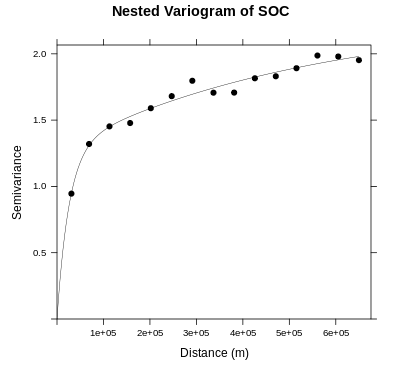

In [14]:
%%R -w 400 -h 375 -u px
# Plot varigram and fitted model:
plot(v.bc, pl=F,
     model=vm.bc,
     col="black",
     cex=0.9,
     lwd=0.5,
     lty=1,
     pch=19,
     main="Nested Variogram of SOC",
     xlab="Distance (m)",
     ylab="Semivariance")


## **K-fold Cross Validation**


K-fold cross-validation is a widely used technique in machine learning and statistics to assess the performance and generalization of a predictive model. It involves dividing a dataset into K subsets or "folds," using K-1 folds for training and the remaining fold for testing. This process is repeated K times, with each fold serving as the test set once. K-fold cross-validation helps to provide a more reliable estimate of a model's performance and its ability to generalize to new, unseen data.

We will use **krige.cv()** to evaluate the model with k-fold cross validation.

In [17]:
%%R
cv<-krige.cv(SOC.bc ~ 1,
         train,              # data
         model = vm.bc,        # fitted varigram model
         nfold=10)           # five-fold cross validation

  |======================================================================| 100%


In [18]:
%%R
summary(cv)

Object of class SpatialPointsDataFrame
Coordinates:
       min        max
x -1246454   95251.19
y  1019863 2526240.55
Is projected: NA 
proj4string : [NA]
Number of points: 368
Data attributes:
   var1.pred         var1.var         observed         residual       
 Min.   :-1.324   Min.   :0.3419   Min.   :-2.922   Min.   :-3.23175  
 1st Qu.: 1.559   1st Qu.:1.0092   1st Qu.: 1.241   1st Qu.:-0.75058  
 Median : 2.129   Median :1.1721   Median : 2.074   Median :-0.04295  
 Mean   : 2.143   Mean   :1.1340   Mean   : 2.126   Mean   :-0.01744  
 3rd Qu.: 2.788   3rd Qu.:1.2900   3rd Qu.: 3.062   3rd Qu.: 0.70259  
 Max.   : 4.460   Max.   :1.5984   Max.   : 5.943   Max.   : 3.30703  
     zscore              fold       
 Min.   :-3.23742   Min.   : 1.000  
 1st Qu.:-0.73694   1st Qu.: 3.000  
 Median :-0.04145   Median : 6.000  
 Mean   :-0.01232   Mean   : 5.519  
 3rd Qu.: 0.66417   3rd Qu.: 8.000  
 Max.   : 3.19342   Max.   :10.000  


### Residuals plot

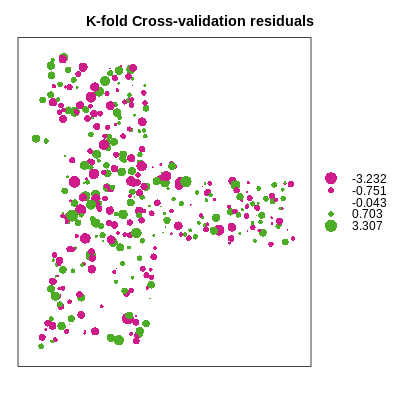

In [20]:
%%R -w 400 -h 400 -u px
bubble(cv, zcol = "residual", maxsize = 2.0,  main = "K-fold Cross-validation residuals")

### Evaluation Matrix

In [22]:
%%R
# Mean Error (ME)
ME<-round(mean(cv$residual),3)
# Mean Absolute Error
MAE<-round(mean(abs(cv$residual)),3)
# Root Mean Squre Error (RMSE)
RMSE<-round(sqrt(mean(cv$residual^2)),3)
# Mean Squared Deviation Ratio (MSDR)
MSDR<-mean(cv$residual^2/cv$var1.var)



In [23]:
%%R
RMSE

[1] 1.114


### Plot Observed vs Predicted values

`geom_smooth()` using formula = 'y ~ x'


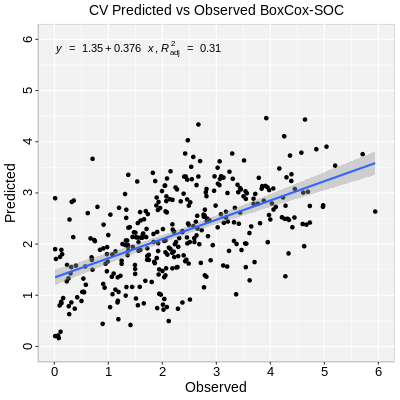

In [35]:
%%R -w 400 -h 400 -u px

cv.df<-as.data.frame(cv)

formula<-y~x

ggplot(cv.df, aes(observed,var1.pred)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("CV Predicted vs Observed BoxCox-SOC") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,6), breaks=seq(0, 6, 1))+
  scale_y_continuous(limits=c(0,6), breaks=seq(0, 6, 1)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

## **Validation with an test Data Set**

In [42]:
%%R
val<-krige(SOC.bc ~ 1,
         train,        # train data
         test,         # test data
         model = vm.bc)

[using ordinary kriging]


In [43]:
%%R
summary(val)

Object of class SpatialPointsDataFrame
Coordinates:
       min        max
x -1186067   70606.76
y  1038971 2502087.41
Is projected: NA 
proj4string : [NA]
Number of points: 101
Data attributes:
   var1.pred         var1.var     
 Min.   :0.2009   Min.   :0.4987  
 1st Qu.:1.4141   1st Qu.:0.9787  
 Median :1.8755   Median :1.1804  
 Mean   :2.0465   Mean   :1.1163  
 3rd Qu.:2.5932   3rd Qu.:1.2847  
 Max.   :4.2629   Max.   :1.4944  


###  Residuals

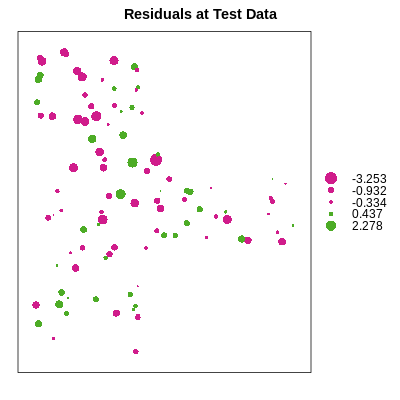

In [45]:
%%R -w 400 -h 400 -u px
test$SOC.pred<-val$var1.pred
test$SOC.var<-val$var1.var
test$residual<-(test$SOC.bc-test$SOC.pred)
bubble(test, zcol = "residual", maxsize = 2.0,  main = "Residuals at Test Data")

In [46]:
%%R
# Mean Error (ME)
ME<-round(mean(test$residual),3)
# Mean Absolute Error
MAE<-round(mean(abs(test$residual)),3)
# Root Mean Squre Error (RMSE)
RMSE<-round(sqrt(mean(test$residual^2)),3)
# Mean Squared Deviation Ratio (MSDR)
MSDR<-mean(test$residual^2/test$SOC.var)
RMSE

[1] 1.072


`geom_smooth()` using formula = 'y ~ x'


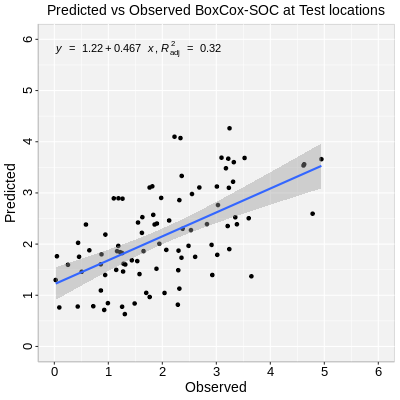

In [47]:
%%R -w 400 -h 400 -u px

test.df<-as.data.frame(test)

formula<-y~x

ggplot(test.df, aes(SOC.bc,SOC.pred)) +
  geom_point() +
  geom_smooth(method = "lm")+
  stat_poly_eq(use_label(c("eq", "adj.R2")), formula = formula) +
  ggtitle("Predicted vs Observed BoxCox-SOC at Test locations") +
  xlab("Observed") + ylab("Predicted") +
  scale_x_continuous(limits=c(0,6), breaks=seq(0, 6, 1))+
  scale_y_continuous(limits=c(0,6), breaks=seq(0, 6, 1)) +
  theme(
    panel.background = element_rect(fill = "grey95",colour = "gray75",size = 0.5, linetype = "solid"),
    axis.line = element_line(colour = "grey"),
    plot.title = element_text(size = 14, hjust = 0.5),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text.x=element_text(size=13, colour="black"),
    axis.text.y=element_text(size=13,angle = 90,vjust = 0.5, hjust=0.5, colour='black'))

## **Point or Punctual Kriging**

In general, point kriging estimate the value of a point from a set of nearby sample values using kriging. To perform kriging, you use the **krige()** function, specifying the variogram model and the location where you want to estimate the variable. The output will be the estimated value and a prediction variance.


In [15]:
%%R
OK<-krige(SOC.bc~1,
              loc= train,        # Data frame
              newdata=grid,      # Prediction grid
              model = vm.bc)     # fitted varigram model

[using ordinary kriging]


In [16]:
%%R
summary(OK)

Object of class SpatialPointsDataFrame
Coordinates:
       min     max
x -1245285  114715
y  1003795 2533795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Data attributes:
   var1.pred         var1.var       
 Min.   :-2.634   Min.   :0.006922  
 1st Qu.: 1.317   1st Qu.:0.889236  
 Median : 2.016   Median :1.109755  
 Mean   : 2.013   Mean   :1.065685  
 3rd Qu.: 2.687   3rd Qu.:1.279553  
 Max.   : 5.620   Max.   :1.679987  


### Back-transformation
We will back transformation using transformation parameters that have used Box-cos transformation

In [36]:
%%R
k1<-1/0.2987656
OK$OK.pred <-((OK$var1.pred *0.2987656 +1)^k1)
OK$OK.var <-((OK$var1.var *0.2987656 +1)^k1)
summary(OK)

Object of class SpatialPointsDataFrame
Coordinates:
       min     max
x -1245285  114715
y  1003795 2533795
Is projected: NA 
proj4string : [NA]
Number of points: 10674
Data attributes:
   var1.pred         var1.var           OK.pred              OK.var     
 Min.   :-2.634   Min.   :0.006922   Min.   : 0.005645   Min.   :1.007  
 1st Qu.: 1.317   1st Qu.:0.889236   1st Qu.: 3.035361   1st Qu.:2.200  
 Median : 2.016   Median :1.109755   Median : 4.845089   Median :2.608  
 Mean   : 2.013   Mean   :1.065685   Mean   : 5.427779   Mean   :2.564  
 3rd Qu.: 2.687   3rd Qu.:1.279553   3rd Qu.: 7.187349   3rd Qu.:2.955  
 Max.   : 5.620   Max.   :1.679987   Max.   :27.069223   Max.   :3.902  


### Convert to Raster

In [37]:
%%R
OK.pred<-rasterFromXYZ(as.data.frame(OK)[, c("x", "y", "OK.pred")])
OK.var<-rasterFromXYZ(as.data.frame(OK)[, c("x", "y", "OK.var")])

### Plot predicted SOC and OK Error

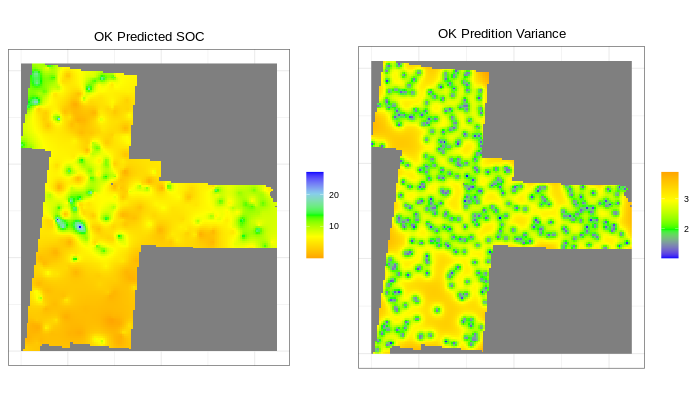

In [38]:
%%R -w 700 -h 400 -u px
# Predicted SOC
p1<-ggR(OK.pred, geom_raster = TRUE) +
scale_fill_gradientn("", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("OK Predicted SOC")+
   theme(plot.title = element_text(hjust = 0.5))
# Error
p2<-ggR(OK.var, geom_raster = TRUE) +
scale_fill_gradientn("", colours = c("blue",  "green","yellow", "orange"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("OK Predition Variance")+
   theme(plot.title = element_text(hjust = 0.5))

grid.arrange(p1,p2, ncol = 2)  # Multiplot

The above plots show the interpolated map of soil SOC with associated error at each prediction grid. OK, the predicted map shows a global pattern and hot spot locations of SOC concentration. The kriging variance is higher in unsampled locations since variance depends on the geometry of the sampling locations with lower variance near sampling locations. This kriging variance also depends on the variance model but is independent of data values.

## **Block Kriging**

Like point kriging, We can use the krige() function with one additional argument: **block**, which gives the block's dimensions as a list. For the usual case of a 2D block (surface area), this is a list of two dimensions (usually, but not necessarily the same).

In [39]:
%%R
OK.block <- krige(SOC.bc ~ 1,
                 loc =  train,
                 newdata = grid,
                 model = vm.bc,
                 block = c(50000, 50000)) # 50 km x 50 km

[using ordinary kriging]


In [40]:
%%R
# Back transformation
k1<-1/0.2987656
OK.block$SOC.pred <-((OK.block$var1.pred *0.2987656+1)^k1)
OK.block$SOC.var <-((OK.block$var1.var *0.2987656+1)^k1)
# Convert to raster
SOC.block.pred<-rasterFromXYZ(as.data.frame(OK.block)[, c("x", "y", "SOC.pred")])
SOC.block.var<-rasterFromXYZ(as.data.frame(OK.block)[, c("x", "y", "SOC.var")])

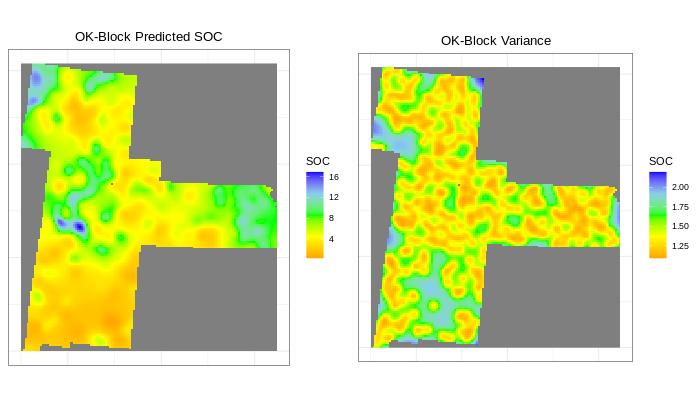

In [41]:
%%R -w 700 -h 400 -u px
# Predicted SOC
p3<-ggR(SOC.block.pred, geom_raster = TRUE) +
scale_fill_gradientn("SOC", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("OK-Block Predicted SOC")+
   theme(plot.title = element_text(hjust = 0.5))

# Error
p4<-ggR(SOC.block.var, geom_raster = TRUE) +
scale_fill_gradientn("SOC", colours = c("orange", "yellow", "green",  "sky blue","blue"))+
  theme_bw()+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
   ggtitle("OK-Block Variance")+
   theme(plot.title = element_text(hjust = 0.5))

grid.arrange(p3,p4, ncol = 2)  # Multiplot

### Further Reading

1. [Introduction to Kriging in R](https://rpubs.com/nabilabd/118172)

2. [Spatial interpolation using kriging in R](https://rpubs.com/Dr_Gurpreet/spatial_interpolation_kriging_R)

3. [Spatial interpolation in R](https://pages.cms.hu-berlin.de/EOL/gcg_quantitative-methods/Lab14_Kriging.html#Sample_variogram)